<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Rhea's_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

If you only have one model, there is no other model to compare against, so elpd_loo on its own does not provide much useful information. It is primarily used to assess the out-of-sample predictive performance of a model and to compare it to other models.

**Task2**:

Describe overfitting, in the context of this course

Overfitting refers to a scenario where a model learns not just the underlying patterns in the data but also the random noise or fluctuations. As a result, the model fits the training data very well but fails to generalize to unseen data. In this course, overfitting typically happens when the model becomes too complex

**Task3**:

How do we mitigate overfitting?

To mitigate overfitting, you can start by simplifying the model. You can do this by reducing the number of predictors or using a less complex model, such as linear regression instead of polynomial regression.

**Task4**:

How do we mitigate underfitting?

To mitigate underfitting, you may need to increase the complexity of your model. This could involve using more predictors or using non-linear models if the relationship between the variables is not well captured by a simple linear model

**Task5**:

Why would we want more than one predictor in a model?

Using multiple predictors in a model allows us to account for more factors that might influence the outcome. With multiple predictors, the model can capture more complex relationships, leading to improved accuracy in predicting the dependent variable.

**Task6**:

Can we have too many predictors? How would we now?

Yes, having too many predictors can lead to problems such as overfitting. If a model has too many predictors, it may start fitting noise in the data, resulting in poor generalization to unseen data. Another problem is where predictors are highly correlated with each other, making it difficult to determine the individual effect of each predictor.

**Task7**:

What is variable selection, and how does it work?

Variable selection is the process of identifying which predictors should be included in a model. It aims to find the most relevant predictors that contribute significantly to the outcome while avoiding unnecessary complexity.It works by evaluating each feature’s relevance to the target variable and then selecting the most important features for the analysis.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

Adding the variables as is: You include both predictors (one continuous and one categorical) in the model separately, treating them independently.

Using the categorical variable as a hierarchy: You model the categorical variable in a way that reflects a structure or hierarchy, such as treating different levels of the categorical variable as separate groups, which can affect how the continuous predictor influences the outcome.

Adding the interaction: You include both predictors as well as their interaction, meaning the effect of one predictor on the outcome may depend on the level of the other predictor, capturing more complex relationships between them

All three models involve using the same two predictors (one continuous and one categorical), but they differ in how they account for their relationship.
The first treats them separately.
The second introduces a structured relationship.
The third considers how the predictors influence the outcome together.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

Visualizing a multiple linear regression model with many predictors is difficult because the model is high-dimensional, meaning it has more than two or three variables. But you can still visualize parts of the model.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Load the dataset and drop rows with missing values
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()

# Define the mapping of positions to numbers
position_mapping = {
    'PG': 1,  # Point Guard
    'SG': 2,  # Shooting Guard
    'SF': 3,  # Small Forward
    'PF': 4,  # Power Forward
    'C': 5    # Center
}

# Apply the mapping to the 'Pos' column
bb['Pos'] = bb['Pos'].map(position_mapping)

# Filter players with more than 600 minutes played
bb = bb.query('MP > 600')

# Remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')

# Filter out the combo positions (keep only individual positions)
bb = bb.query("Pos in [1, 2, 3, 4, 5]")  # Corresponding to PG, SG, SF, PF, C

# Rename columns to remove the '%' sign
bb.rename(columns={"FT%": "FTp", "FG%": "FGp"}, inplace=True)


In [3]:
bb

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,5.0,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,2.0,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,4.0,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,2.0,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,2.0,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Jalen Wilson,4.0,23,BRK,43,3,664,76,179,0.425,...,47,84,131,45,11,4,19,48,214,wilsoja03
563,James Wiseman,5.0,22,DET,63,6,1091,187,305,0.613,...,110,226,336,54,12,39,66,141,446,wisemja01
565,Christian Wood,4.0,28,LAL,50,1,872,123,264,0.466,...,39,215,254,49,16,33,50,72,347,woodch01
566,Delon Wright,1.0,31,TOT,47,1,742,74,188,0.394,...,19,67,86,119,54,11,14,32,210,wrighde01


In [4]:
#bb stands for negative basket ball model
with pm.Model() as model_bb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=2)
    β = pm.Normal("β", mu=0, sigma=1)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bb.FTp))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bb.Pos)

    #we need the log likelihood for model comparison later
    idata_bb = pm.sample(idata_kwargs={"log_likelihood":True})


Output()

Output()

In [5]:
pm.sample_posterior_predictive(idata_bb, model = model_bb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
#mlb stands for multiple linear basket
with pm.Model() as model_mlb:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=2)
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=1)

    #linear part of the model
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bb.FTp + β1 * bb.FTA))

    #prior for the standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bb.Pos)

    #we need the log likelihood for model comparison later
    idata_mlb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [7]:
pm.sample_posterior_predictive(idata_mlb, model = model_mlb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

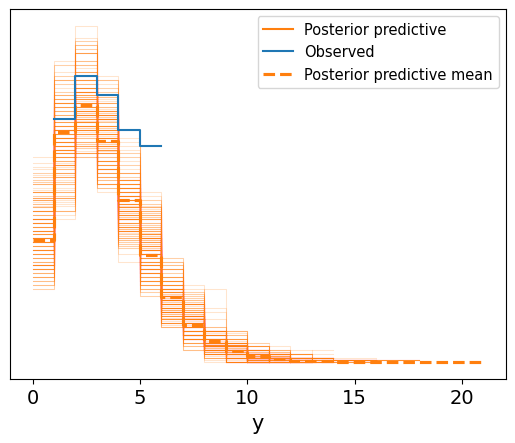

In [8]:
az.plot_ppc(idata_bb, num_pp_samples=200, colors=["C1", "C0", "C1"])

<Axes: xlabel='y'>

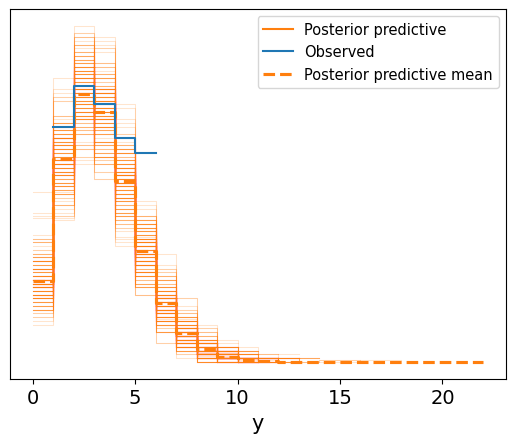

In [9]:
az.plot_ppc(idata_mlb, num_pp_samples=200, colors=["C1", "C0", "C1"])

In [10]:
az.loo(idata_mlb)

,0
elpd_loo,-568.405226
se,5.674323
p_loo,1.535298
n_samples,2000
n_data_points,322
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [11]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"multi_lin":idata_mlb,"single_lin":idata_bb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-568.405226,1.535298,0.000000,1.000000e+00,5.674323,0.000000,False,log
single_lin,1,-596.176380,0.795439,27.771154,2.330580e-12,5.614133,2.236035,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

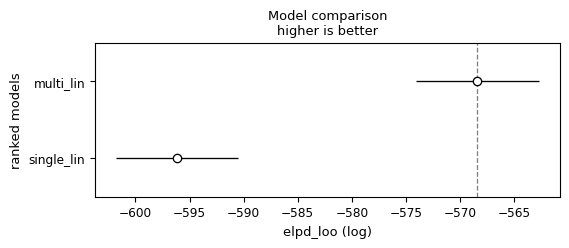

In [12]:
az.plot_compare(cmp_df)

In [13]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-k4hhrtg1
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-k4hhrtg1
  Resolved https://github.com/pydata/xarray.git to commit 70997ef021358c22bfc632a23a6da8e14c8abb42
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
import xarray as xr

In [15]:
!pip install bambi

  Using cached bambi-0.15.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached formulae-0.5.4-py3-none-any.whl.metadata (4.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.1 MB/s eta 0:00:00


In [16]:
import bambi as bmb

In [17]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [18]:
#we put the priors that aren't normal or half normal with mean 0 and sigma 1
#in a dict
priors ={"FTp" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_bb_bmb = bmb.Model("Pos ~ FTp", bb, family = "negativebinomial", priors=priors)

In [19]:
model_bb_bmb

       Formula: Pos ~ FTp
        Family: negativebinomial
          Link: mu = log
  Observations: 322
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            FTp ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfNormal(sigma: 10.0)

In [20]:
#this is bambi's equivalent of pm.sample()
idata_bb_bmb = model_bb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


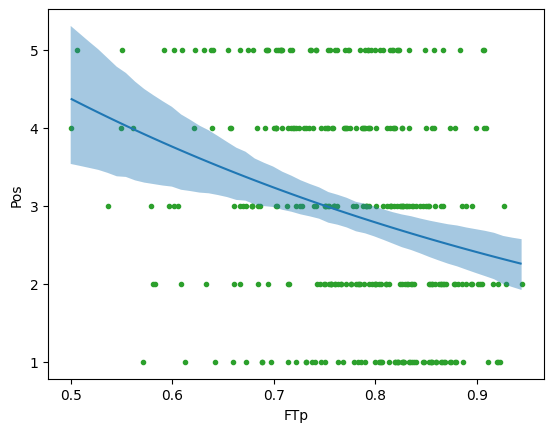

In [21]:
bmb.interpret.plot_predictions(model_bb_bmb, idata_bb_bmb, "FTp")
plt.plot(bb.FTp, bb.Pos, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


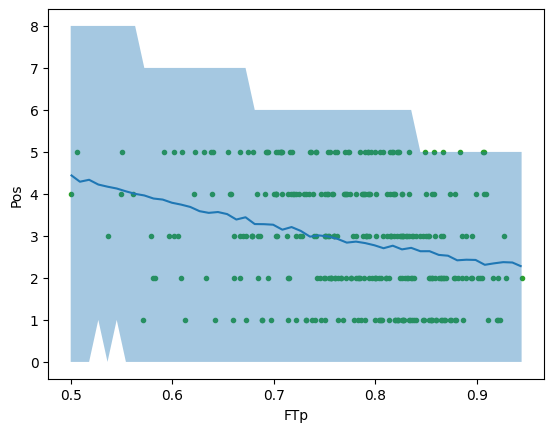

In [22]:
bmb.interpret.plot_predictions(model_bb_bmb, idata_bb_bmb, "FTp", pps=True)
plt.plot(bb.FTp, bb.Pos, "C2.", zorder=-3)

In [23]:
model_mlb_bmb = bmb.Model("Pos ~ FTp + FTA", bb, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'FTA = 4'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 19'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 35'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 51'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 67'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 83'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 99'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 115'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 131'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 146'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 162'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 178'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 194'}, xlabel='F

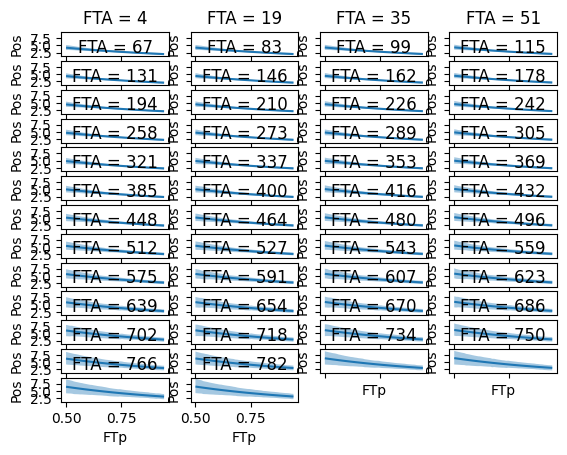

In [24]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["FTp", "FTA"],
                               subplot_kwargs={"group":None, "panel":"FTA"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'FTA = 4'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 19'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 35'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 51'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 67'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 83'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 99'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 115'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 131'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 146'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 162'}, xlabel='FTp', ylabel='Pos'>,
         <Axes: title={'center': 'FTA = 178'}, xlabel='FTp', ylabel='Pos'>],
        [<Axes: title={'center': 'FTA = 194'}, xlabel='F

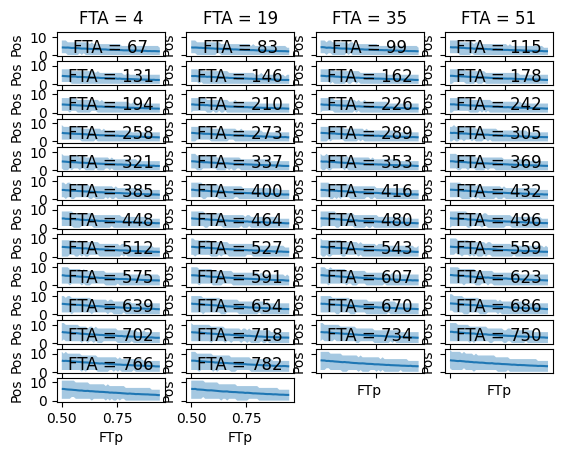

In [25]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["FTp", "FTA"],
                               subplot_kwargs={"group":None, "panel":"FTA"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True},pps=True)

In [26]:
cmp_df_bmb = az.compare( {"multi_lin":idata_mlb_bmb,"single_lin":idata_bb_bmb} )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-562.068066,1.786058,0.000000,1.000000e+00,6.008926,0.000000,False,log
single_lin,1,-569.702645,1.063210,7.634579,5.329071e-15,5.785764,1.739554,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

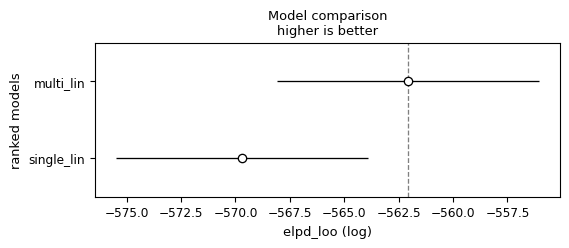

In [27]:
az.plot_compare(cmp_df_bmb)

In [39]:
#have to drop incomplete rows, so that bambi will run
basketball = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv').dropna()


#only look at players who played more than 400 minutes
basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
basketball = basketball.query('`FT%` != 1.0')


#filter out the combo positions. This will make it easier to read the graphs
basketball = basketball.query("Pos in ['C','PF','SF','SG','PG']")


#define the model
model_basketball = bmb.Model("`FTA` ~ `FT%` + Pos", data=basketball)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FTA'>], dtype=object))

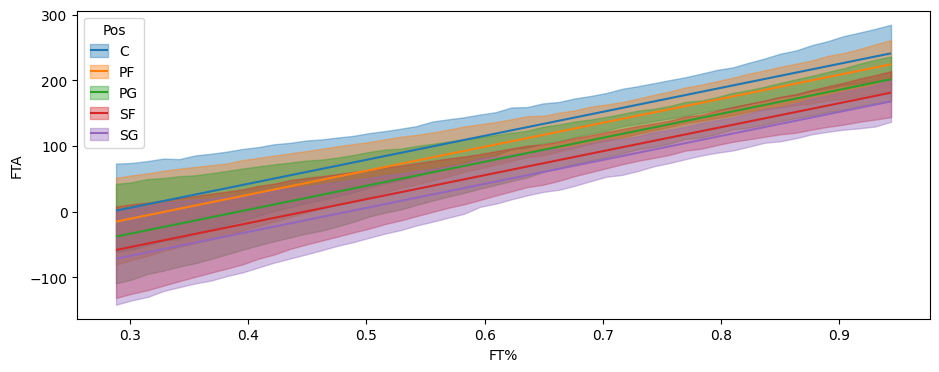

In [40]:
bmb.interpret.plot_predictions(model_basketball,
                               idata_basketball,
                                ["FT%",  "Pos"], fig_kwargs={"figsize":(11, 4)})

In [41]:
model_basketball_h = bmb.Model("`FTA` ~ (`FT%`|Pos)", data=basketball)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FTA'>], dtype=object))

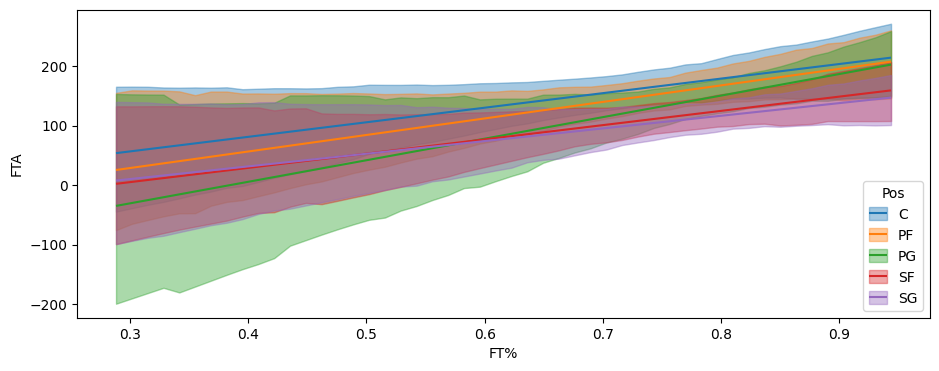

In [42]:
bmb.interpret.plot_predictions(model_basketball_h,
                               idata_basketball_h,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

In [48]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`3PA` ~ `FT%` + Pos + `FT%`:Pos", data=basketball)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='3PA'>], dtype=object))

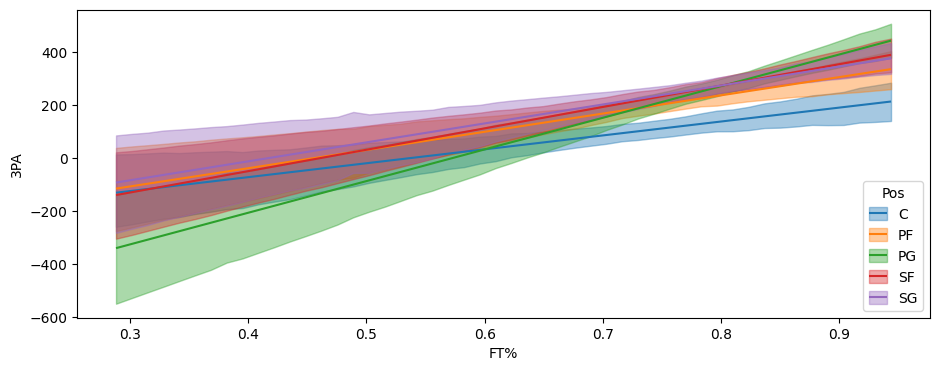

In [49]:
bmb.interpret.plot_predictions(model_bb_inter,
                               idata_bb_inter,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

In [63]:
#define the model; bb_interq stands for baskeball interaction quantiative
model_bb_interq = bmb.Model("`FTA` ~ `FT%` + `3PA` + `FT%`:`3PA`", data=basketball)
#create the model
idata_bb_interq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FTA'>], dtype=object))

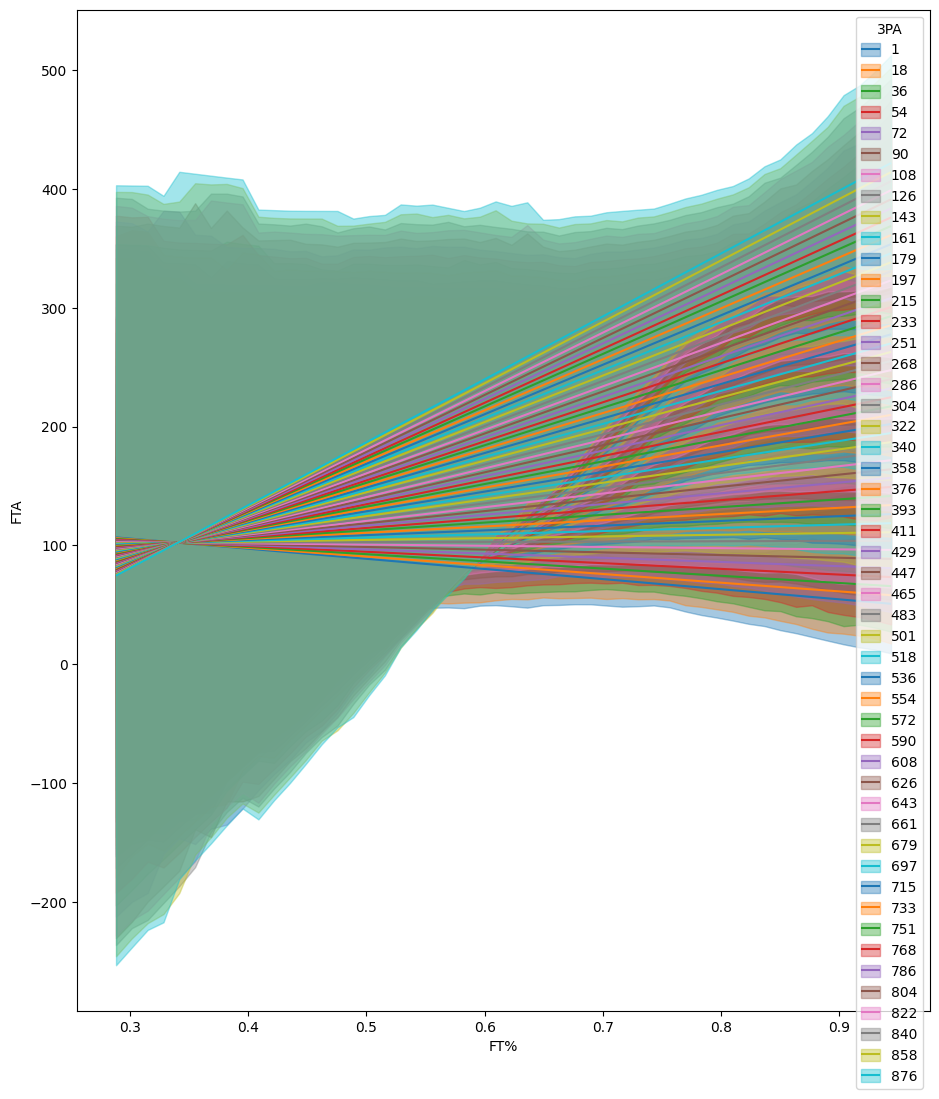

In [61]:
bmb.interpret.plot_predictions(model_bb_interq,
                               idata_bb_interq,
                               ["FT%","3PA"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

Probably model 4 which includes free throw percentage, position, three-point attempts, and interactions between all three predictors, because it captures the most complex relationships and seems to have the best predictive performance. But I think that model 2 is more simple and less prone to overfitting so its not bad either